#### AI 수업 끝나고 챌린지 팀플 전까지 개인플레이 시작 🤬
#### 🎬 

# 딥러닝 순환 신경망으로 악성 URL 탐지하기(Malicious URL Detection with RNN)
#### 2020 AI 챌린지 대회 웹로그 이상행위 패턴분석의 재료로 쓰세요!  
#### 원본 비정상 이메일 분석 코드의 링크는 아래에 있습니다!
fork Spam_Filtering.ipynb  
https://github.com/witcher42/KISA_AI_Security/blob/master/docs/Spam_Filtering.ipynb


In [24]:
import numpy as np
import pandas as pd
import random
%matplotlib inline
import matplotlib.pyplot as plt
import urllib.request
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [25]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/Jcharis/Machine-Learning-In-Julia-JCharisTech/master/urldata.csv", filename="url.csv")
data = pd.read_csv('url.csv')

In [26]:
print('데이터 개수 :',len(data))

데이터 개수 : 420464


In [27]:
data[:5]

,url,label
0,diaryofagameaddict.com,bad
1,espdesign.com.au,bad
2,iamagameaddict.com,bad
3,kalantzis.net,bad
4,slightlyoffcenter.net,bad


In [28]:
# good과 bad 레이블을 0과 1로!!!!!!!!!
data['label'] = data['label'].replace(['good','bad'],[0,1])
data[:5]

,url,label
0,diaryofagameaddict.com,1
1,espdesign.com.au,1
2,iamagameaddict.com,1
3,kalantzis.net,1
4,slightlyoffcenter.net,1


In [29]:
data.isnull().values.any()

False

In [30]:
data['url'].nunique(), data['label'].nunique()
# 총 420,464개의 샘플이 존재  
# url에서 중복을 제거한 샘플의 개수가 411,247개라는 것은 중복 샘플이 존재한다는 의미

(411247, 2)

In [33]:
data.drop_duplicates(subset=['url'], inplace=True)

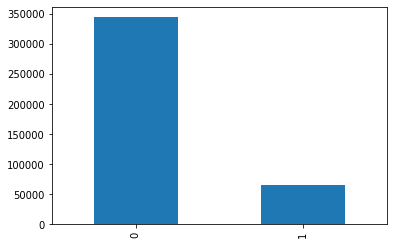

In [ ]:
data['url'].value_counts().plot(kind='bar');

In [34]:
# 대다수의 악성 URL 데이터가 정상이다  
print(data.groupby('label').size().reset_index(name='count'))

   label   count
0      0  344800
1      1   66447


In [35]:
X_data = data['url']
y_data = data['label']
print('중복 제거 후 URL 개수: {}'.format(len(X_data)))

중복 제거 후 URL 개수: 411247
레이블의 개수: 411247


In [36]:
# 내장함수 사용하여 url 분리. 이게 바로 자동화 아니겠슴니꽈
vectorizer = TfidfVectorizer()
tokenX = vectorizer.fit_transform(X_data)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(tokenX, y_data, test_size=0.2, random_state=42)

In [38]:
LR = LogisticRegression(max_iter=500, random_state=42)	
# Life is 42
LR.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [39]:
print("\n 테스트 정확도: %.4f" % (LR.score(X_test, y_test)))


 테스트 정확도: 0.9652


In [40]:
# 등장 빈도수가 1회 밖에 되지 않는 단어들이 전체 단어 집합에서 얼만큼의 비율을 차지하며,   
# 전체 훈련 데이터에서 등장 빈도로 얼만큼의 비율을 차지하는지 확인  
threshold = 2
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_data) # 5X의 각 행에 토큰화를 수행
sequences = tokenizer.texts_to_sequences(X_data) # 단어를 숫자로  
word_to_index = tokenizer.word_index
total_cnt = len(word_to_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

In [41]:
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

In [42]:
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합(vocabulary)에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

등장 빈도가 1번 이하인 희귀 단어의 수: 284716
단어 집합(vocabulary)에서 희귀 단어의 비율: 74.30287878115679
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 9.503734019886956


등장 빈도가 __threshold__ 값인 2회 미만. 즉, 1회 밖에 되지 않는 단어들은 단어 집합에서 무려 74% 이상을 차지합니다.   
하지만, 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 적은 수치인 9.5%밖에 되지 않습니다. 

In [43]:
# 집합의 크기를 vocab_size에 저장하겠습니다  
# 주의할 점은 패딩을 위한 토큰인 0번 단어를 고려하며 +1을 해서 저장해주어야 한다는 점
vocab_size = len(word_to_index) + 1
print('단어 집합의 크기: {}'.format((vocab_size)))

단어 집합의 크기: 383184


In [44]:
# 정수 인코딩 된 결과인 sequences
n_of_train = int(len(sequences) * 0.8)
n_of_test = int(len(sequences) - n_of_train)
print('훈련 데이터의 개수 :',n_of_train)
print('테스트 데이터의 개수:',n_of_test)

훈련 데이터의 개수 : 328997
테스트 데이터의 개수: 82250


URL의 최대 길이 : 177
URL의 평균 길이 : 7.284753


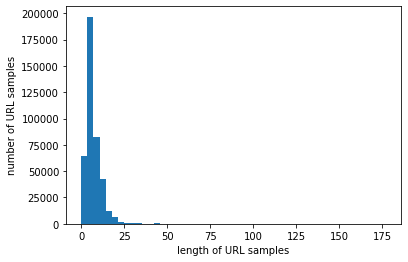

In [45]:
# sequences를 X_data로 변경  
X_data = sequences
print('URL의 최대 길이 : %d' % max(len(l) for l in X_data))
print('URL의 평균 길이 : %f' % (sum(map(len, X_data))/len(X_data)))
plt.hist([len(s) for s in X_data], bins=50)
plt.xlabel('length of URL samples')
plt.ylabel('number of URL samples')
plt.show()

# RNN으로 악성 URL 분류하기

In [20]:
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense
from tensorflow.keras.models import Sequential

In [21]:
max_len = 177
# 전체 데이터셋의 길이는 URL 최대길이로 맞춥니다.
data = pad_sequences(X_data, maxlen=max_len)
print("훈련 데이터의 크기(shape): ", data.shape)

훈련 데이터의 크기(shape):  (420464, 177)


In [ ]:
X_test = data[n_of_train:] #X_data 데이터 중에서 앞의 82250개 저장
y_test = np.array(y_data[n_of_train:]) #y_data 데이터 중에서 앞의 82250개 저장
X_train = data[:n_of_train] #X_data 데이터 중에서 뒤의 328997개 저장
y_train = np.array(y_data[:n_of_train]) #y_data 데이터 중에서 뒤의 328997개 저장

In [ ]:
model = Sequential()
# Embedding()은 두 개의 인자를 받습니다.  
# 단어 집합의 크기, 임베딩 벡터의 차원입니다.  
model.add(Embedding(vocab_size, 32)) # 임베딩 벡터의 차원은 32
model.add(SimpleRNN(32)) # RNN 셀의 hidden_size는 32
# 이진 분류 문제 이므로 마지막 출력층에는 1개의 뉴런과 활성화 함수로 시그모이드 함수를 사용합니다.  
model.add(Dense(1, activation='sigmoid'))
# 손실 함수로는 binary_crossentropy를 사용합니다.
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
history = model.fit(X_train, y_train, epochs=4, batch_size=64, validation_split=0.2)

Epoch 1/4
4113/4113 [==============================] - 340s 83ms/step - loss: 0.0972 - acc: 0.9646 - val_loss: 0.1049 - val_acc: 0.9605
Epoch 2/4
4113/4113 [==============================] - 347s 84ms/step - loss: 0.0502 - acc: 0.9833 - val_loss: 0.2412 - val_acc: 0.9225
Epoch 3/4
4113/4113 [==============================] - 345s 84ms/step - loss: 0.0292 - acc: 0.9909 - val_loss: 0.2729 - val_acc: 0.9166
Epoch 4/4
4113/4113 [==============================] - 348s 85ms/step - loss: 0.0267 - acc: 0.9912 - val_loss: 0.2450 - val_acc: 0.9372


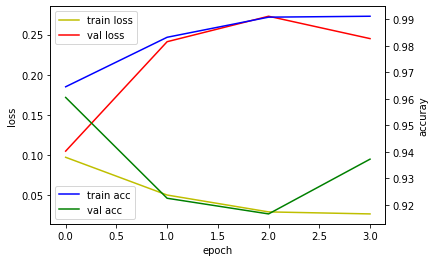

In [ ]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()
loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')
loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')
plt.show()

## 엄청난 오버핏...  미쳤습니까 휴먼?

In [ ]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping()
history = model.fit(X_train, y_train, epochs=2, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/2
4113/4113 [==============================] - 349s 85ms/step - loss: 0.0140 - acc: 0.9958 - val_loss: 0.3292 - val_acc: 0.9263
Epoch 2/2
4113/4113 [==============================] - 347s 84ms/step - loss: 0.0148 - acc: 0.9955 - val_loss: 0.3729 - val_acc: 0.9053


In [ ]:
model.evaluate(X_test, y_test)

2571/2571 [==============================] - 22s 9ms/step - loss: 0.4873 - acc: 0.8473


[0.487343430519104, 0.8472704887390137]

## ..은 오버핏이 아니였던 것으로 밝혀졌습니다